In [8]:
from spks import *
import numpy as np
from labdata.schema import *

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.rcParams.update({'font.size': 16})


In [9]:
# Grab mice/probes with similar implantation trajectories
#TODO: ADD JC123
SAVEPATH = Path(r'/home/mmelin/chronic_manuscript_figures')
SUBJECTS = ['_AL031','_AL032','_AL036','MM013','MM018','JC131']
PROBE_NUMS = [0,0,0,2,2,0]

cemented_subjects = SUBJECTS[:3]
chronic_holder_subjects = SUBJECTS[3:]

subjects = '(' + ','.join([f'"{s}"' for s in SUBJECTS]) + ')'
dat = pd.DataFrame()
for s,p in zip(SUBJECTS,PROBE_NUMS):
    unit_counts = Session() * UnitCount() & dict(subject_name=s,
                                                 probe_num=p,
                                                 parameter_set_num=5,
                                                 unit_criteria_id=1)
    subject_data = unit_counts.proj('session_datetime','all','sua','mua').fetch(format='frame')
    dat = pd.concat([dat,subject_data])
dat = dat.reset_index()
dat.head()

,subject_name,session_name,dataset_name,probe_num,parameter_set_num,unit_criteria_id,session_datetime,all,sua,mua
0,_AL031,2019-12-02,ephys,0,5,1,2019-12-02,289,35,254
1,_AL031,2019-12-03,ephys,0,5,1,2019-12-03,298,40,258
2,_AL031,2019-12-13,ephys,0,5,1,2019-12-13,258,24,234
3,_AL031,2020-01-07,ephys,0,5,1,2020-01-07,292,28,264
4,_AL031,2020-01-16,ephys,0,5,1,2020-01-16,294,34,260


In [10]:
cemented_sessions = dat[dat.subject_name.isin(cemented_subjects)]
chronic_holder_sessions = dat[dat.subject_name.isin(chronic_holder_subjects)]

# randomly subsample our chronic holder mice so that they're equal in number for randomly selecting sessions
min_num_sessions = chronic_holder_sessions.subject_name.value_counts().min()
subsample_group = lambda group, n_per_subject:  group.sample(n=n_per_subject, replace=True) 
chronic_holder_sessions = chronic_holder_sessions.groupby('subject_name', group_keys=False).apply(subsample_group, n_per_subject=min_num_sessions)
min_num_sessions

44

In [11]:
n_random = 3 
n_to_pick = 1
fdict = {'size': 12}

c_mice,h_mice,h_deltadays, c_deltadays, c_sua, c_mua, h_mua, h_sua = [],[],[],[],[],[],[],[]
for i,cemented_session in cemented_sessions.iterrows():
    cem_delta_days = (cemented_session.session_datetime - cemented_sessions.session_datetime.min()).days
    hol_delta_days = np.array([x.days for x in chronic_holder_sessions.session_datetime - chronic_holder_sessions.session_datetime.min()])
    sorted_day_distance = np.argsort(np.abs(hol_delta_days-cem_delta_days))
    ff = np.random.choice(sorted_day_distance[:n_random],n_to_pick,replace=False)
    comparison_sessions = chronic_holder_sessions.iloc[ff]
    #print(cemented_session.subject_name, cemented_session.session_name, comparison_sessions.iloc[0].subject_name, comparison_sessions.iloc[0].session_name)
    c_sua.append(cemented_session.sua)
    c_mua.append(cemented_session.mua)
    deltadays = cemented_session.session_datetime - cemented_sessions.session_datetime.min()
    c_deltadays.append(deltadays.days)
    c_mice.append(cemented_session.subject_name)

    h_sua.append(comparison_sessions.sua.mean())
    h_mua.append(comparison_sessions.mua.mean())
    deltadays = comparison_sessions.session_datetime - chronic_holder_sessions.session_datetime.min()
    h_deltadays.append(deltadays.iloc[0].days)
    h_mice.append(comparison_sessions.iloc[0].subject_name)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


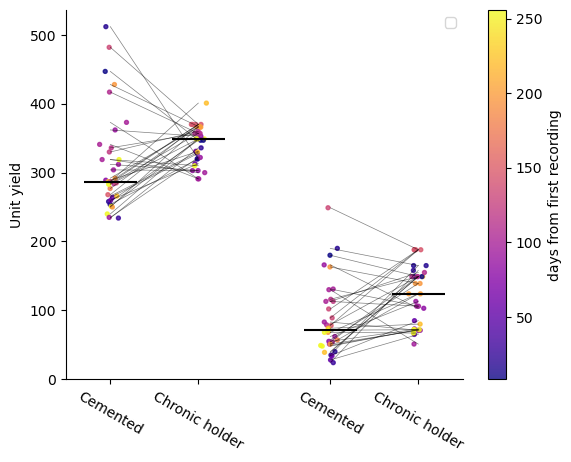

In [12]:
# plot the number of units for several session from the cemented probes and the chronic holder
import matplotlib.patches as mpatches

_, h_cols = np.unique(h_mice, return_inverse=True)
_, c_cols = np.unique(c_mice, return_inverse=True)

labels = ['Cemented','Chronic holder'] * 2
leg_labels = []
xticks = (1,2,3.5,4.5)
for i,(pos,n_units) in enumerate(zip(xticks,[c_mua, h_mua, c_sua, h_sua])):
    scatter_positions = np.random.normal(0, scale=.05, size=len(n_units))
    #parts = plt.violinplot([n_units],[pos], showmedians=False, showextrema=False, showmeans=False)
    #plt.scatter(pos+scatter_positions, n_units, s=5, color='black', alpha=.8)
    if i % 2 == 0:
        #scatter_positions = c_cols / 5
        plt.scatter(pos+scatter_positions, n_units, s=8, c=c_deltadays, alpha=.8, cmap='plasma')
    else:
        #scatter_positions = h_cols / 5
        plt.scatter(pos+scatter_positions, n_units, s=8, c=h_deltadays, alpha=.8, cmap='plasma')

    plt.hlines(np.median(n_units), pos-.3, pos+.3, color='black')
    #if i % 2 == 0:
    #    col = 'grey'
    #else:
    #    col = 'purple'

    #for pc in parts['bodies']:
    #    pc.set_facecolor(col)
    #    pc.set_edgecolor('black')
    #    pc.set_alpha(1)
    #color = parts['bodies'][0].get_facecolor().flatten()
    #if i == 0:
    #    leg_labels.append((mpatches.Patch(color=color), 'multi unit'))
    #elif i == 1:
    #    leg_labels.append((mpatches.Patch(color=color), 'single units'))

nsess = len(c_mua)
plt.plot(np.repeat(np.expand_dims(xticks[:2],1),nsess, axis=1), np.stack([c_mua, h_mua], axis=1).T, linewidth=.5, color='black', alpha=.5)
plt.plot(np.repeat(np.expand_dims(xticks[2:],1),nsess, axis=1), np.stack([c_sua, h_sua], axis=1).T, linewidth=.5, color='black', alpha=.5)

plt.colorbar(label='days from first recording')

plt.xticks(xticks, labels)
plt.xticks(rotation=-30)
plt.ylabel('Unit yield')
plt.xlabel('')
plt.gca().spines[['right', 'top']].set_visible(False)
plt.legend(*zip(*leg_labels), loc = 1)
plt.savefig(SAVEPATH / 'cemented_comparison_unit_yield.pdf', bbox_inches='tight', dpi=300, format='pdf')
plt.show()

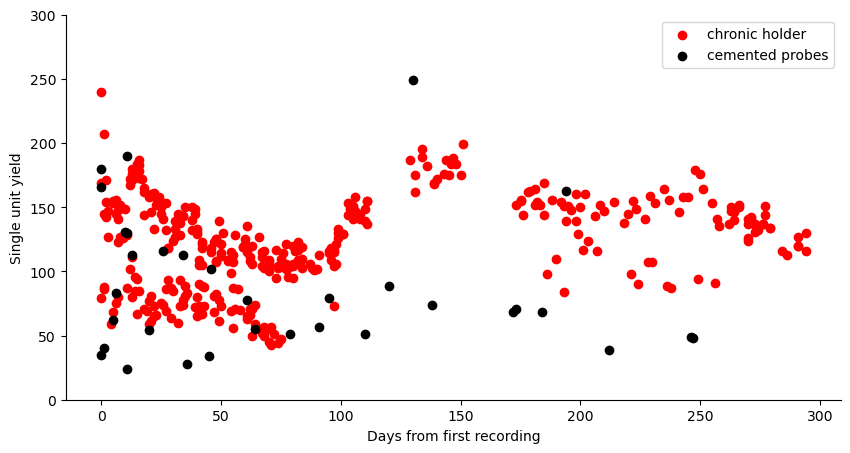

In [13]:
i,j = 0,0
n_subsample = 5000
fig, ax = plt.subplots(figsize=(10,5))
for sess, session_data in dat.groupby('subject_name'):
    days_from_first_recording = np.array([x.days for x in session_data.session_datetime - session_data.session_datetime.min()])
    if '_' in sess:
        if i==0:
            plt.scatter(days_from_first_recording, session_data.sua, color='black',label='cemented probes')
        else:
            plt.scatter(days_from_first_recording, session_data.sua, color='black')
        i+=1
    else:
        #subsample_inds = np.random.choice(np.arange(len(days_from_first_recording)), n_subsample, replace=False)
        subsample_inds = slice(None)
        if j==0:
            plt.scatter(days_from_first_recording[subsample_inds], session_data.sua[subsample_inds], color='red',label='chronic holder')
        else:
            plt.scatter(days_from_first_recording[subsample_inds], session_data.sua[subsample_inds], color='red')
        j+=1
    

plt.legend()
plt.xlabel('Days from first recording')
plt.ylabel('Single unit yield')
plt.ylim(0,300)
plt.gca().spines[['right', 'top']].set_visible(False)
plt.show()